In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>\n{css}\n</style>"))

# Chapter 1 — Introduction to Machine Learning
# Lesson 5: History and Evolution of Machine Learning

Machine learning (ML) did not appear fully formed. It emerged from multiple traditions—statistics, control theory, cybernetics, pattern recognition, and later computer science and large-scale software engineering.

This lesson is designed for practitioners. You will learn the historical storyline **and** translate it into practical intuitions that help you choose models and build reliable experiments today.

## Learning objectives

By the end of this lesson you should be able to:

1. Describe major eras of ML development and what made each era feasible (or infeasible): data, compute, theory, and tooling.
2. Explain why certain model families became dominant at specific times (linear models, trees, kernel methods, ensembles, deep learning).
3. Connect historical milestones to modern concepts: loss functions, optimization, regularization, validation, and deployment.
4. Implement “historically representative” models and compare them on real(ish) data.
5. Use a reproducible experimental pattern: fixed random seeds, explicit preprocessing, and comparable evaluation.

## Reading guide

- Markdown: narrative + key concepts.
- Code: short experiments that reinforce the narrative. Cells are executed so outputs are visible.
- Dataset paths match your repository layout (e.g., `"../../../Datasets/Classification/iris.csv"`). If files are missing, the notebook falls back to embedded samples (so this lesson can run anywhere).

## A recurring historical cycle

A large part of ML history repeats this pattern:

1. A **representation** idea appears (features, kernels, neural architectures).
2. An **optimization** idea makes it trainable (convex surrogates, gradient methods, numerical tricks).
3. A **generalization** idea controls overfitting (regularization, validation protocols, capacity measures).
4. A **systems** idea makes it usable at scale (tooling, pipelines, deployment, monitoring).

When you see a “new wave” of ML, look for these four ingredients.

## 1. Timeline view: key eras and representative ideas

The dates below are approximate and meant to capture sequencing. Several threads evolved in parallel; history is rarely linear.

### 1.1 Early roots (pre-1950): statistics, estimation, and decision theory

Before the phrase “machine learning” was popular, much of its mathematical backbone already existed:

- **Probability and inference:** maximum likelihood estimation, Bayesian reasoning, hypothesis testing.
- **Linear models:** regression ideas matured into modern statistical practice.
- **Decision theory:** selecting actions under uncertainty; losses and utilities as formal objects.

Many modern workflows—likelihood-based modeling, calibration, and even the language of “risk minimization”—descend from this era.

### 1.2 1950s–1960s: cybernetics, perceptrons, and early optimism

This era introduced early learning systems and pattern recognition ideas.

- **Perceptron (Rosenblatt, 1957/1958):** a linear classifier trained with a mistake-driven update.
- **Symbolic AI emerges alongside learning:** rules, logic, and hand-built systems.
- **Severe constraints:** limited data and compute, leading to toy problems and conceptual demonstrations.

A classic update rule for a linear classifier can be written as:

$$
w \leftarrow w + \eta (y - \hat{y}) x
$$

where $\eta$ is the learning rate, $x$ is the feature vector, and $y$ / $\hat{y}$ are the true / predicted labels.

### 1.3 1970s–1980s: “AI winter”, but stronger statistical learning

The critique of perceptrons (e.g., XOR limitations of single-layer models) cooled enthusiasm, but other lines advanced:

- Classical statistics + pattern recognition matured.
- Decision trees and early ensemble ideas appeared.
- Backpropagation was re-popularized in the mid-1980s, enabling multi-layer neural nets via gradients.

### 1.4 1990s: kernels, convex optimization, and a theory culture

The 1990s saw rigorous framing and methods that performed well with limited data:

- **SVMs:** maximize margins; kernels allow nonlinear decision boundaries.
- **Convex optimization:** stability and (sometimes) guarantees.
- **Regularization:** explicit complexity control (e.g., $L_2$ penalties).

A common objective template is:

$$
\min_{f \in \mathcal{F}} \frac{1}{n} \sum_{i=1}^{n} \ell\big(y_i, f(x_i)\big) + \lambda \Omega(f)
$$

### 1.5 2000s: ensembles, big data, and applied ML infrastructure

As data and compute grew, applied performance became the central focus:

- Random forests and boosting became extremely strong on tabular data.
- Evaluation practices standardized: cross-validation, held-out tests, reproducible splits.
- Tooling matured: feature pipelines, reproducible experimentation, and later monitoring.

### 1.6 2010s–present: deep learning and representation learning at scale

Deep learning dominated vision, speech, and language, enabled by:

- Large datasets (or weak supervision / self-supervision),
- GPUs/TPUs,
- Improved optimization and normalization methods,
- Architectural breakthroughs (CNNs, RNNs/LSTMs, attention, transformers).

Classical ML remains central for many tabular business problems due to interpretability and governance constraints.

### 1.7 What “history” teaches in practice

When you choose a model today, you are making historical tradeoffs:

- Linear structure: simplicity and interpretability.
- Tree ensembles: nonlinear interactions with minimal feature engineering.
- Kernel methods: strong geometric inductive biases for medium-sized data.
- Deep models: learned representations, but higher cost and governance complexity.

We will connect these ideas to experiments.

## 2. Environment setup and reproducibility

Modern ML values reproducibility. Many historical results were later found fragile because protocols were not standardized.

We will:
- Fix random seeds.
- Print library versions (useful when results differ across machines).
- Use pipelines so preprocessing is applied consistently.

Reproducibility is not the same as correctness, but it is required for trust and debugging.

In [2]:
import sys, platform, numpy as np, pandas as pd
import sklearn

np.random.seed(42)

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)

Python: 3.13.0
Platform: Windows-10-10.0.19045-SP0
NumPy: 2.1.2
Pandas: 2.2.3
scikit-learn: 1.5.2


## 3. Loading datasets the “repo way” (with safe fallbacks)

Your repository uses relative paths such as:

- `../../../Datasets/Classification/iris.csv`
- `../../../Datasets/Regression/house-prices.csv`
- `../../../Datasets/Clustering/hw_200.csv`

The code below tries to load those files. If a file is missing, it loads a small embedded sample so the lesson can run outside the repo.

This pattern is valuable in tutorial repos: it teaches the *real layout* without making the notebook brittle.

In [3]:
from pathlib import Path
from io import StringIO
import random

def load_csv_or_sample(rel_path: str, sample_csv_text: str, **read_csv_kwargs):
    p = Path(rel_path)
    if p.exists():
        df = pd.read_csv(p, **read_csv_kwargs)
        source = f"file: {rel_path}"
    else:
        df = pd.read_csv(StringIO(sample_csv_text.strip()), **read_csv_kwargs)
        source = f"embedded sample (because '{rel_path}' not found)"
    return df, source

classification_candidates = [
    ("../../../Datasets/Classification/iris.csv", "sepal_length,sepal_width,petal_length,petal_width,classification\n5.4,3.7,1.5,0.2,Iris-setosa\n4.8,3.4,1.6,0.2,Iris-setosa\n4.8,3,1.4,0.1,Iris-setosa\n4.3,3,1.1,0.1,Iris-setosa\n5.8,4,1.2,0.2,Iris-setosa\n"),
    ("../../../Datasets/Classification/diabetes.csv", "Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification\n6,148,72,35,0,33.6,0.627,50,Diabetic\n1,85,66,29,0,26.6,0.351,31,Non-Diabetic\n8,183,64,0,0,23.3,0.672,32,Diabetic\n1,89,66,23,94,28.1,0.167,21,Non-Diabetic\n0,137,40,35,168,43.1,2.288,33,Diabetic\n"),
    ("../../../Datasets/Classification/drug200.csv", "Age,Sex,BP,Cholesterol,Na_to_K,Drug\n23,F,HIGH,HIGH,25.355,DrugY\n47,M,LOW,HIGH,13.093,drugC\n47,M,LOW,HIGH,10.114,drugC\n28,F,NORMAL,HIGH,7.798,drugX\n61,F,LOW,HIGH,18.043,DrugY\n22,F,NORMAL,HIGH,8.607,drugX\n"),
]
regression_candidates = [
    ("../../../Datasets/Regression/house-prices.csv", "Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood\n1,114300,1790,2,2,2,No,East\n2,114200,2030,4,2,3,No,East\n3,114800,1740,3,2,1,No,East\n4,94700,1980,3,2,3,No,East\n5,119800,2130,3,3,3,No,East\n"),
    ("../../../Datasets/Regression/salaries.csv", "Name,Age,Job,Salary\nKevin Sanders,24,Software Engineer,7300\nLisa Mills,26,High School Teacher,6100\nDonna Allison,27,Dentist,12700\nMichael Schmitt,43,Dentist,17500\nLisa Shaffer,31,Accountant,7400\n"),
    ("../../../Datasets/Classification/Wine_Quality.csv", "fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality\n7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6\n6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6\n8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6\n7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6\n7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6\n8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6\n"),
]
clustering_candidates = [
    ("../../../Datasets/Clustering/hw_200.csv", "\"Index\",Height(Inches),Weight(Pounds)\n1,65.78,112.99\n2,71.52,136.49\n3,69.40,153.03\n4,68.22,142.34\n5,67.79,144.30\n6,68.70,123.30\n"),
]

rng = random.Random(7)
cls_path, cls_sample = rng.choice(classification_candidates)
reg_path, reg_sample = rng.choice(regression_candidates)
clu_path, clu_sample = rng.choice(clustering_candidates)

df_cls, src_cls = load_csv_or_sample(cls_path, cls_sample)
df_reg, src_reg = load_csv_or_sample(reg_path, reg_sample)
df_clu, src_clu = load_csv_or_sample(clu_path, clu_sample)

print("Selected classification dataset:", cls_path, "|", src_cls)
print("Selected regression dataset:", reg_path, "|", src_reg)
print("Selected clustering dataset:", clu_path, "|", src_clu)

df_cls.head(), df_reg.head(), df_clu.head()

Selected classification dataset: ../../../Datasets/Classification/diabetes.csv | file: ../../../Datasets/Classification/diabetes.csv
Selected regression dataset: ../../../Datasets/Regression/house-prices.csv | file: ../../../Datasets/Regression/house-prices.csv
Selected clustering dataset: ../../../Datasets/Clustering/hw_200.csv | file: ../../../Datasets/Clustering/hw_200.csv


(   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0            6      148             72             35        0  33.6   
 1            1       85             66             29        0  26.6   
 2            8      183             64              0        0  23.3   
 3            1       89             66             23       94  28.1   
 4            0      137             40             35      168  43.1   
 
    DiabetesPedigreeFunction  Age classification  
 0                     0.627   50       Diabetic  
 1                     0.351   31   Non-Diabetic  
 2                     0.672   32       Diabetic  
 3                     0.167   21   Non-Diabetic  
 4                     2.288   33       Diabetic  ,
    Home   Price  SqFt  Bedrooms  Bathrooms  Offers Brick Neighborhood
 0     1  114300  1790         2          2       2    No         East
 1     2  114200  2030         4          2       3    No         East
 2     3  114800  1740         3        

## 4. Historically-inspired models (with experiments)

We recreate the “feel” of major eras by running representative models:

- Perceptron (1950s): mistake-driven updates and linear separability.
- Logistic Regression (statistical tradition): probabilistic classification with convex loss.
- SVM (1990s kernel era): margin maximization and strong generalization behavior.
- Decision Trees (1980s+): interpretable splits and nonlinear structure.
- Random Forests (2000s): bagging and variance reduction.

These are “proxies” for eras. In reality, the field evolved through overlapping threads.

### 4.1 Preparing the classification dataset

Real datasets do not share standardized column names. We will:

- Infer the target column name.
- Split numeric vs categorical features.
- Build a preprocessing + model pipeline.

Pipeline discipline is a *modern* best practice that historically reduced leakage and made experiments repeatable.

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def infer_classification_target(df: pd.DataFrame):
    for c in ["classification", "Drug", "Type"]:
        if c in df.columns:
            return c
    last = df.columns[-1]
    if not pd.api.types.is_numeric_dtype(df[last]):
        return last
    raise ValueError("Could not infer classification target column.")

target_col = infer_classification_target(df_cls)
X = df_cls.drop(columns=[target_col]).copy()
y_raw = df_cls[target_col].copy()

le = LabelEncoder()
y = le.fit_transform(y_raw)

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

print("Target column:", target_col)
print("Classes:", list(le.classes_))
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Target column: classification
Classes: ['Diabetic', 'Non-Diabetic']
Numeric columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Categorical columns: []
Train size: (514, 8) Test size: (254, 8)


### 4.2 Perceptron: the early learning rule

The Perceptron introduced a compelling idea: a model can improve itself by adjusting parameters after mistakes. Its limitation is equally important: it converges only for linearly separable data (in the feature space).

We compare it with Logistic Regression, SVM, and tree-based methods.

In [5]:
models = {
    "Perceptron": Perceptron(random_state=42, max_iter=1000, tol=1e-3),
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "SVM (RBF)": SVC(kernel="rbf", C=3.0, gamma="scale"),
    "DecisionTree": DecisionTreeClassifier(max_depth=4, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=50, random_state=42),
}

rows = []
for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rows.append((name, float(accuracy_score(y_test, pred))))

pd.DataFrame(rows, columns=["Model", "Test Accuracy"]).sort_values("Test Accuracy", ascending=False)

,Model,Test Accuracy
1,LogisticRegression,0.763780
0,Perceptron,0.748031
3,DecisionTree,0.748031
4,RandomForest,0.744094
2,SVM (RBF),0.740157


### 4.3 Cross-validation: the evaluation culture shift

As ML matured, the community moved away from anecdotal demos toward standardized protocols. Cross-validation is a simple but powerful tool to estimate performance more reliably than a single split.

We will compute cross-validated accuracy for a few representative models.

In [6]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

subset = {
    "LogisticRegression": models["LogisticRegression"],
    "SVM (RBF)": models["SVM (RBF)"],
    "RandomForest": models["RandomForest"],
}

cv_rows = []
for name, model in subset.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
    cv_rows.append((name, float(scores.mean()), float(scores.std())))

pd.DataFrame(cv_rows, columns=["Model", "CV Mean Accuracy", "CV Std"]).sort_values("CV Mean Accuracy", ascending=False)

,Model,CV Mean Accuracy,CV Std
0,LogisticRegression,0.772135,0.013279
2,RandomForest,0.752604,0.021710
1,SVM (RBF),0.736979,0.009744


### 4.4 A minimal “from scratch” Perceptron (binary)

To see the mechanics, we implement a tiny Perceptron and train it on a synthetic dataset. Synthetic datasets are historically important because they isolate phenomena such as separability and label noise.

In [7]:
import numpy as np

rng_np = np.random.default_rng(42)
X_toy = rng_np.normal(size=(200, 2))
y_toy = (X_toy[:, 0] + 0.6 * X_toy[:, 1] > 0).astype(int)

flip_idx = rng_np.choice(len(y_toy), size=12, replace=False)
y_toy[flip_idx] = 1 - y_toy[flip_idx]

def perceptron_fit(X, y, lr=0.2, epochs=20):
    Xb = np.c_[np.ones(len(X)), X]
    w = np.zeros(Xb.shape[1])
    history = []
    for ep in range(epochs):
        errors = 0
        for xi, yi in zip(Xb, y):
            y_hat = 1 if (w @ xi) >= 0 else 0
            update = lr * (yi - y_hat)
            if update != 0:
                w += update * xi
                errors += 1
        history.append(errors)
    return w, history

w, hist = perceptron_fit(X_toy, y_toy, lr=0.2, epochs=25)
w, hist[:10], ("final epoch updates", hist[-1])

(array([0.        , 0.61770205, 0.19685164]),
 [42, 37, 42, 40, 36, 40, 42, 41, 38, 39],
 ('final epoch updates', 43))

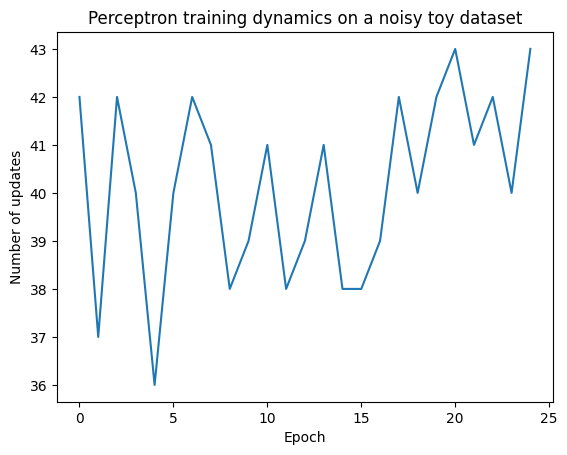

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hist)
plt.xlabel("Epoch")
plt.ylabel("Number of updates")
plt.title("Perceptron training dynamics on a noisy toy dataset")
plt.show()

## 5. Regression and the statistical tradition

Regression is one of the oldest modeling paradigms. It provided clear objectives (least squares), interpretability, and analytical solutions in simple cases.

For linear regression, the canonical objective is:

$$
\min_w \sum_{i=1}^{n} (y_i - w^T x_i)^2
$$

We will run a small regression experiment and compare Linear Regression, Ridge, and Lasso.

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

def infer_regression_target(df: pd.DataFrame):
    for c in ["Price", "Salary", "kid_score", "quality", "magnitude"]:
        if c in df.columns:
            return c
    for c in reversed(df.columns):
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    raise ValueError("Could not infer regression target column.")

reg_target = infer_regression_target(df_reg)
Xr = df_reg.drop(columns=[reg_target]).copy()
yr = df_reg[reg_target].astype(float).copy()

num_cols_r = [c for c in Xr.columns if pd.api.types.is_numeric_dtype(Xr[c])]
cat_cols_r = [c for c in Xr.columns if c not in num_cols_r]

preprocess_r = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_r),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_r),
    ]
)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.33, random_state=42)

reg_models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0),
    "Lasso(alpha=0.05)": Lasso(alpha=0.05, max_iter=3000),
}

rows = []
for name, model in reg_models.items():
    pipe = Pipeline([("prep", preprocess_r), ("model", model)])
    pipe.fit(Xr_train, yr_train)
    pred = pipe.predict(Xr_test)
    mae = float(mean_absolute_error(yr_test, pred))
    rmse = float(np.sqrt(mean_squared_error(yr_test, pred)))
    r2 = float(r2_score(yr_test, pred))
    rows.append((name, mae, rmse, r2))

print("Regression target column:", reg_target)
pd.DataFrame(rows, columns=["Model", "MAE", "RMSE", "R^2"]).sort_values("RMSE")

Regression target column: Price


,Model,MAE,RMSE,R^2
1,Ridge(alpha=1.0),8209.975616,10600.854893,0.832444
2,Lasso(alpha=0.05),8261.290198,10713.497960,0.828864
0,LinearRegression,8261.296309,10713.516018,0.828863


### 5.2 Regularization as capacity control

As models and feature spaces grew, overfitting became central. Regularization became mainstream both due to theory and due to better software support.

- Ridge uses an $L_2$ penalty: $\Omega(w) = \|w\|_2^2$
- Lasso uses an $L_1$ penalty: $\Omega(w) = \|w\|_1$

A unified template is:

$$
\min_w \frac{1}{n}\sum_{i=1}^n (y_i - w^T x_i)^2 + \lambda \|w\|_p
$$

where $p=2$ (Ridge) or $p=1$ (Lasso).

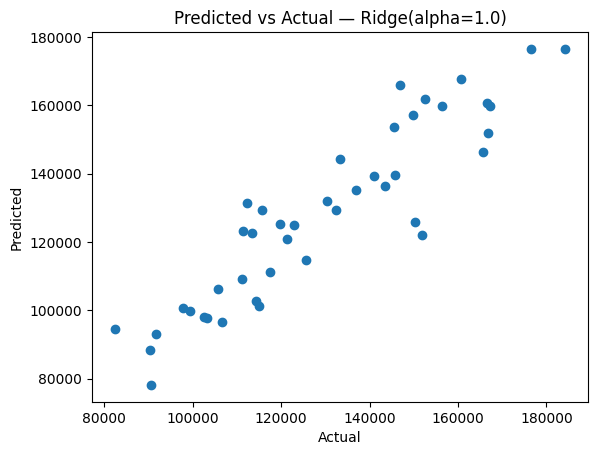

In [10]:
# Simple diagnostic plot: predicted vs actual for the best RMSE model
best = sorted(rows, key=lambda r: r[2])[0][0]
best_model = reg_models[best]

best_pipe = Pipeline([("prep", preprocess_r), ("model", best_model)])
best_pipe.fit(Xr_train, yr_train)
pred = best_pipe.predict(Xr_test)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(yr_test, pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual — {best}")
plt.show()

## 6. Unsupervised learning: clustering as a recurring need

Labels are expensive. Clustering appeared early in pattern recognition and remains practical for segmentation, exploration, and triage.

We run K-Means on a simple numeric dataset (height/weight) and evaluate with inertia and silhouette score.

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

Xc = df_clu.select_dtypes(include=[np.number]).copy()
Xc.columns = [str(c).strip().replace('"','') for c in Xc.columns]
Xc = Xc.dropna()

print("Clustering data shape:", Xc.shape)
Xc.head()

Clustering data shape: (200, 3)


,Index,Height(Inches),Weight(Pounds)
0,1,65.78,112.99
1,2,71.52,136.49
2,3,69.40,153.03
3,4,68.22,142.34
4,5,67.79,144.30


In [12]:
Ks = [2, 3, 4]
rows_k = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xc)
    inertia = float(km.inertia_)
    sil = float(silhouette_score(Xc, labels)) if len(set(labels)) > 1 and len(Xc) > k else float("nan")
    rows_k.append((k, inertia, sil))

pd.DataFrame(rows_k, columns=["k", "Inertia", "Silhouette"]).sort_values("k")

,k,Inertia,Silhouette
0,2,195026.974262,0.581016
1,3,102782.574128,0.506875
2,4,69842.055703,0.457648


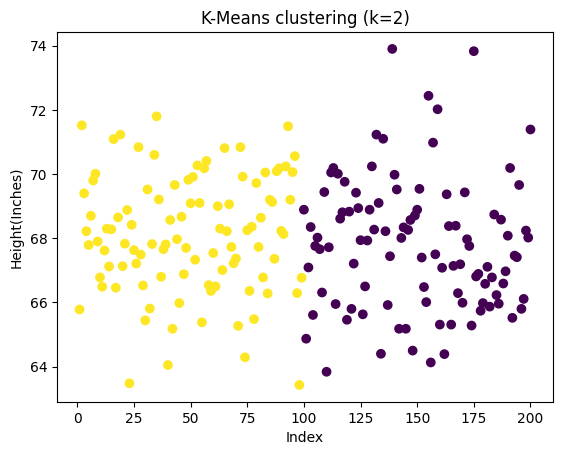

In [13]:
import matplotlib.pyplot as plt

km2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels2 = km2.fit_predict(Xc)

plt.figure()
plt.scatter(Xc.iloc[:, 0], Xc.iloc[:, 1], c=labels2)
plt.xlabel(Xc.columns[0])
plt.ylabel(Xc.columns[1])
plt.title("K-Means clustering (k=2)")
plt.show()

## 7. Model selection culture: tuning as a systematic process

Once compute increased and tooling improved, hyperparameter tuning became routine. Instead of a full grid search (which can be expensive), we demonstrate a lightweight loop over a few values of $C$ for an SVM.

This illustrates the modern idea: “a model is not just an algorithm; it is an algorithm + hyperparameters + a protocol.”

In [14]:
# Lightweight tuning loop for SVM C (instead of full grid search)
C_values = [0.5, 1.0, 3.0, 10.0]
tune_rows = []
for C in C_values:
    pipe = Pipeline([("prep", preprocess), ("model", SVC(kernel="rbf", gamma="scale", C=C))])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
    tune_rows.append((C, float(scores.mean()), float(scores.std())))

pd.DataFrame(tune_rows, columns=["C", "CV Mean Accuracy", "CV Std"]).sort_values("CV Mean Accuracy", ascending=False)

,C,CV Mean Accuracy,CV Std
0,0.5,0.755208,0.006639
1,1.0,0.751302,0.007366
2,3.0,0.736979,0.009744
3,10.0,0.720052,0.023073


## 8. Mini case study: era-style comparison and diagnostics

We pick the best model (by test accuracy on our held-out split) and display:
- a classification report, and
- a confusion matrix.

This mirrors modern practice: metrics + diagnostics, not just a single number.

Best model on this split: LogisticRegression | accuracy: 0.7637795275590551

Classification report:

              precision    recall  f1-score   support

    Diabetic       0.70      0.57      0.63        89
Non-Diabetic       0.79      0.87      0.83       165

    accuracy                           0.76       254
   macro avg       0.74      0.72      0.73       254
weighted avg       0.76      0.76      0.76       254



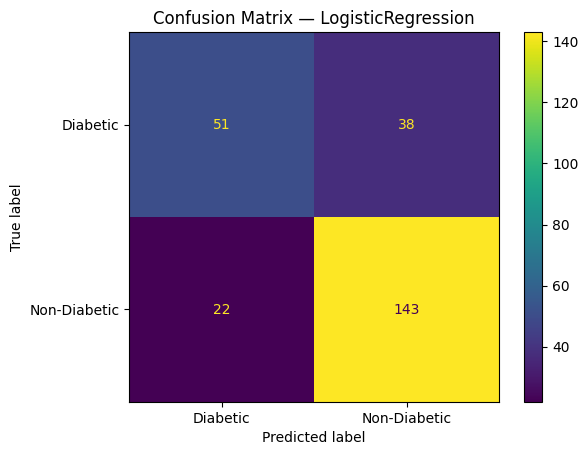

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_name, best_acc = None, -1.0
best_pipe = None

for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = float(accuracy_score(y_test, pred))
    if acc > best_acc:
        best_name, best_acc = name, acc
        best_pipe = pipe

print("Best model on this split:", best_name, "| accuracy:", best_acc)

pred = best_pipe.predict(X_test)
print("\nClassification report:\n")
print(classification_report(y_test, pred, target_names=le.classes_))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.title(f"Confusion Matrix — {best_name}")
plt.show()

## 9. Synthesis: what changed over time (and what did not)

Major historical shifts often reflect changes in constraints:

- More data
- More compute
- Better optimization and numerical stability
- Stronger evaluation norms
- Richer ecosystems and tooling

What did not change is the core loop:

1. Choose a hypothesis space $\mathcal{F}$.
2. Choose a loss $\ell$ (and usually regularization $\Omega$).
3. Optimize on training data.
4. Validate generalization.
5. Deploy with monitoring and governance.

History is largely the story of how each step became more powerful and more standardized.

## 10. Practitioner's checklist: using history to choose models

For tabular problems, a historically-informed default workflow is:

1. Start with a regularized linear baseline.
2. Try tree ensembles (often strongest classical performance).
3. Consider more complex methods only when you have evidence they add value under your constraints (latency, interpretability, governance, cost).

Use history as a way to reason about tradeoffs, not as a rulebook.

## 11. Exercises (recommended)

1. Change the random seed controlling dataset selection and observe how conclusions change.
2. Add a linear SVM and compare its behavior to the RBF SVM.
3. Increase tree depth and compare train vs test accuracy to see overfitting.
4. For regression, plot predicted vs actual values and inspect systematic errors.
5. Write a short reflection: “Which era’s ideas are most useful for your projects and why?”

## Appendix: quick milestone table (non-exhaustive)

| Era | Representative idea | What made it work | Common limitations |
|---|---|---|---|
| Pre-1950 | Statistics & inference | Mathematical foundations | Limited automation, small data |
| 1950s–60s | Perceptron | Simple learning rule | Linear separability |
| 1980s | Backprop + MLPs | Gradient training | Stability, compute |
| 1990s | SVMs + kernels | Convex optimization, margins | Scaling to huge data |
| 2000s | Random forests, boosting | Better compute + data | Interpretability, tuning |
| 2010s+ | Deep learning, transformers | GPUs/TPUs, tooling | Cost, governance, data hunger |